In [1]:
# Importing the required libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [3]:
'''Setting up the env'''

TRAIN_DIR = './TestData'
TEST_DIR = './TrainData'

IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
LR = 1e-3


'''Setting up the model which will help with tensorflow models'''
MODEL_NAME = 'XrayImagesToCovidPrediction-{}-{}.model'.format(LR, '6conv-basic') 

data_dir = pathlib.Path(TRAIN_DIR)
test_dir = pathlib.Path(TEST_DIR)
print(data_dir)
train_image_count = len(list(data_dir.glob('*/*.*')))

test_image_count = len(list(test_dir.glob('*/*.*')))

print(train_image_count)
print(test_dir)
print(test_image_count)

TestData
338
TrainData
1560


In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 338 files belonging to 2 classes.


In [5]:
print(train_ds.class_names)
class_names = train_ds.class_names

['negative', 'positive']


In [6]:
###
#train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#  data_dir,
#  seed=123,
 # image_size=(IMG_HEIGHT, IMG_WIDTH),
 # batch_size=BATCH_SIZE)
###

In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 1560 files belonging to 2 classes.


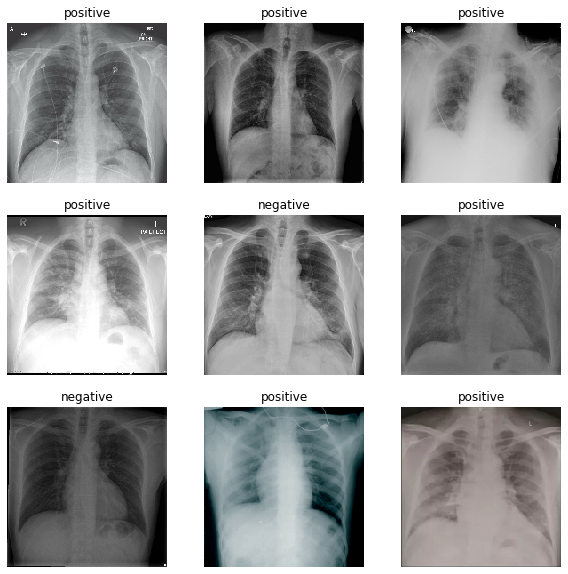

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [12]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
11/11 [==============================] - 30s 3s/step - loss: 0.9570 - accuracy: 0.5325 - val_loss: 0.7209 - val_accuracy: 0.1404
Epoch 2/10
11/11 [==============================] - 12s 1s/step - loss: 0.6918 - accuracy: 0.5059 - val_loss: 0.8106 - val_accuracy: 0.1404
Epoch 3/10
11/11 [==============================] - 12s 1s/step - loss: 0.6843 - accuracy: 0.5917 - val_loss: 0.7521 - val_accuracy: 0.1442
Epoch 4/10
11/11 [==============================] - 12s 1s/step - loss: 0.6512 - accuracy: 0.6568 - val_loss: 0.5418 - val_accuracy: 0.8699
Epoch 5/10
11/11 [==============================] - 12s 1s/step - loss: 0.6121 - accuracy: 0.6686 - val_loss: 0.5437 - val_accuracy: 0.7667
Epoch 6/10
11/11 [==============================] - 12s 1s/step - loss: 0.5485 - accuracy: 0.7160 - val_loss: 0.6697 - val_accuracy: 0.6449
Epoch 7/10
11/11 [==============================] - 12s 1s/step - loss: 0.4810 - accuracy: 0.7840 - val_loss: 0.9499 - val_accuracy: 0.5327
Epoch 8/10
11/11 [==

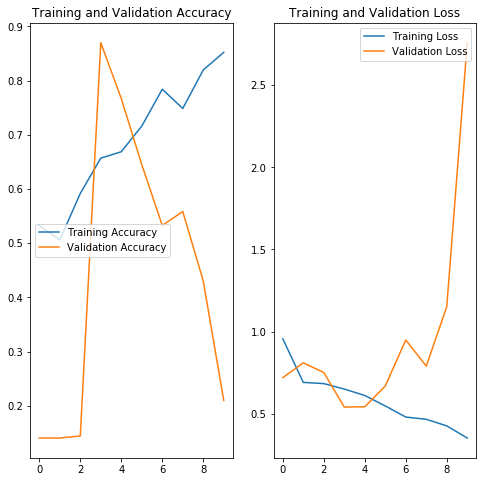

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='center left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

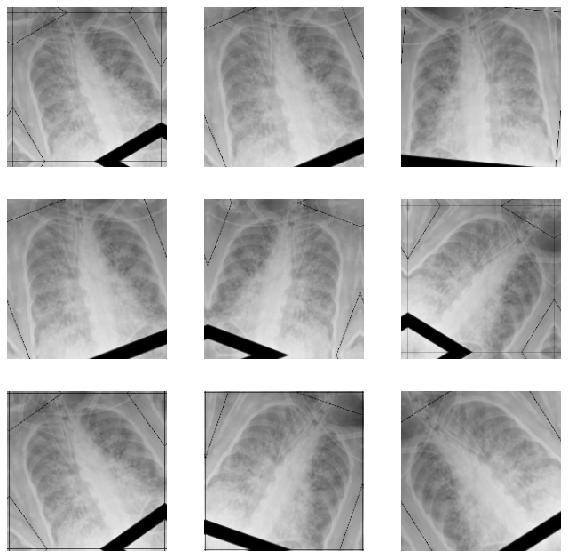

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [22]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
11/11 [==============================] - 9s 846ms/step - loss: 0.4637 - accuracy: 0.7870 - val_loss: 0.9749 - val_accuracy: 0.5026
Epoch 2/15
11/11 [==============================] - 12s 1s/step - loss: 0.4098 - accuracy: 0.8225 - val_loss: 2.5288 - val_accuracy: 0.2564
Epoch 3/15
11/11 [==============================] - 12s 1s/step - loss: 0.3268 - accuracy: 0.8550 - val_loss: 2.0375 - val_accuracy: 0.3551
Epoch 4/15
11/11 [==============================] - 12s 1s/step - loss: 0.2789 - accuracy: 0.8935 - val_loss: 1.3021 - val_accuracy: 0.5321
Epoch 5/15
11/11 [==============================] - 12s 1s/step - loss: 0.2818 - accuracy: 0.8757 - val_loss: 1.4800 - val_accuracy: 0.4949
Epoch 6/15
11/11 [==============================] - 12s 1s/step - loss: 0.2256 - accuracy: 0.9053 - val_loss: 3.2447 - val_accuracy: 0.2968
Epoch 7/15
11/11 [==============================] - 12s 1s/step - loss: 0.1956 - accuracy: 0.9142 - val_loss: 1.8206 - val_accuracy: 0.4737
Epoch 8/15
11/11 [

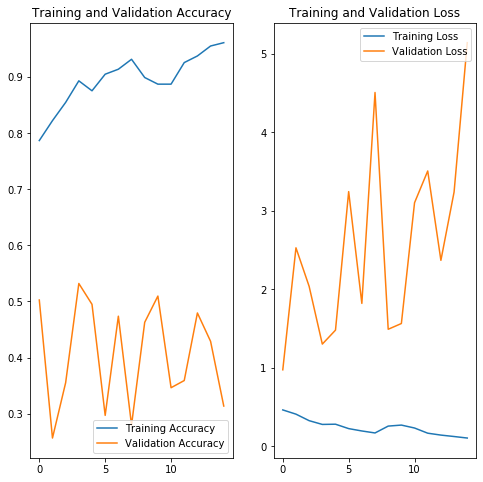

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [66]:
#test_dir = pathlib.Path(TEST_DIR)
test_neg = './TestData/CR.1.2.840.113564.192168196.2020031913094890017.1203801020003.png'
img = keras.preprocessing.image.load_img(
    test_neg
    , target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to positive with a 99.98 percent confidence.


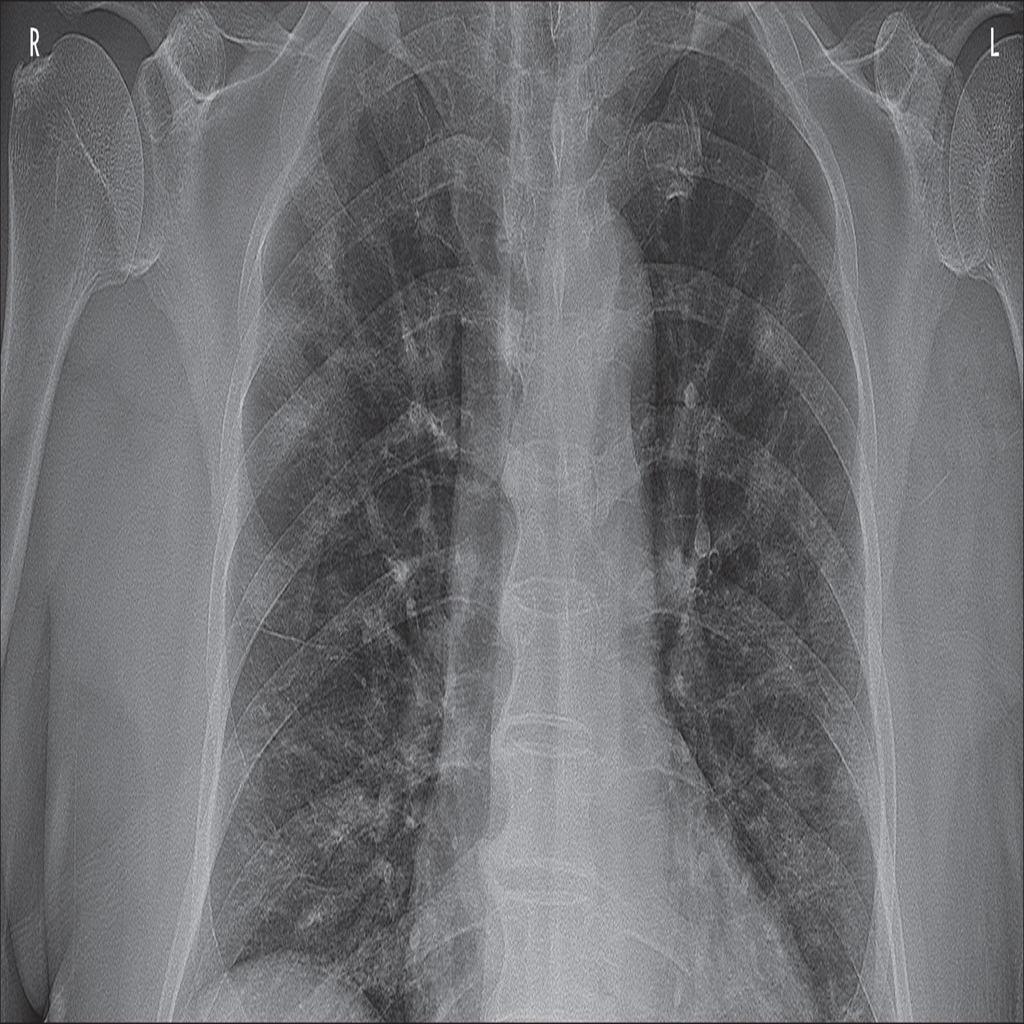

In [67]:
pos = list(data_dir.glob('positive/*'))
PIL.Image.open(str(pos[0]))

In [68]:
test_neg = './TestData/CR.1.2.840.113564.1722810170.202003211940047348.1003000225002.png'
img = keras.preprocessing.image.load_img(
    test_neg
    , target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to positive with a 100.00 percent confidence.
